# Titanic Dataset

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = 'datasets'

In [3]:
import os

In [4]:
def load_titanic_data(filename, path=DATA_PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [5]:
train_data = load_titanic_data('train.csv')

In [6]:
test_data = load_titanic_data('test.csv')

In [7]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Parameter Meanings

* **Survived** 1 = survived, 0 = not
* **PassengerId** Id of passenger
* **Pclass** Cabin class of travelling passenger, placeholder for socio-economic class
* **Name, Sex, Age** Same meaning as in real-life
* **SibSp** Number of siblings and/or spouses travelling with the passenger
* **Parch** Number of parents and children of the passenger
* **Ticket** Ticket number
* **Fare** Amount paid by passenger
* **Cabin** Cabin number of passenger
* **Embarked** Embarkation port

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


* The `Name` and the `Ticket` features could offer some insight but they could be too complex to convert now
* The `Cabin` feature has only 204 non-null values. We can safely ignore this variable too
* We will be using the remaining features

In [9]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

* So about **38%** `Survived`
* The mean `Age` was around 30 years
* The mean `Fare` was around 32 years

In [10]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [11]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

## Pipeline creation

In [14]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [15]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

### Numerical Pipeline

In [17]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age', 'SibSp', 'Fare', 'Parch'])),
    ('imputer', Imputer(strategy='median'))
])

In [18]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  7.25  ,  0.    ],
       [38.    ,  1.    , 71.2833,  0.    ],
       [26.    ,  0.    ,  7.925 ,  0.    ],
       ...,
       [28.    ,  1.    , 23.45  ,  2.    ],
       [26.    ,  0.    , 30.    ,  0.    ],
       [32.    ,  0.    ,  7.75  ,  0.    ]])

### Categorical Pipeline

First, we need to create an imputer of categorical values that fills all the values with the most frequent value

In [19]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

Since scikit-learn v0.19 doesn't support directly encoding one-hot strings, we'll use a mightily helpful API created by Aurelion Geron at [Github](https://github.com/ageron/handson-ml/blob/master/future_encoders.py)

In [20]:
from future_encoders import OneHotEncoder

In [21]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Sex', 'Pclass', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('one-hot-encode', OneHotEncoder(sparse=False))
])

In [22]:
cat_pipeline.fit_transform(train_data)

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

Both of the pipelines are working. Now, to combine them.

In [23]:
from sklearn.pipeline import FeatureUnion

In [24]:
full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [25]:
X_train = full_pipeline.fit_transform(train_data)
X_train

array([[22.    ,  1.    ,  7.25  , ...,  0.    ,  0.    ,  1.    ],
       [38.    ,  1.    , 71.2833, ...,  1.    ,  0.    ,  0.    ],
       [26.    ,  0.    ,  7.925 , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [28.    ,  1.    , 23.45  , ...,  0.    ,  0.    ,  1.    ],
       [26.    ,  0.    , 30.    , ...,  1.    ,  0.    ,  0.    ],
       [32.    ,  0.    ,  7.75  , ...,  0.    ,  1.    ,  0.    ]])

Now we have data that we can work with.

In [26]:
y_train = train_data['Survived'] # Labels

## Training Models

### SVM Classifier

In [27]:
from sklearn.svm import SVC

In [28]:
svm_clf = SVC()

In [29]:
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
svm_pred = svm_clf.predict(X_train)

In [32]:
accuracy_score(y_train, svm_pred)

0.8877665544332211

Okay, that's not too bad. But could it be that we're overfitting?

In [33]:
from sklearn.model_selection import cross_val_score

In [34]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)

In [35]:
svm_scores.mean()

0.7365250822835092

Huh. It was overfitting.

Let's try a better model. My favorite, the `RandomForest`

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
forest_clf = RandomForestClassifier()

In [39]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

In [40]:
forest_scores.mean()

0.8037416297809555

Not bad. This places us in the top 10% of Kagglers!

We can plot all of those scores on a scatter plot, just to visualize the tightness of their spread.

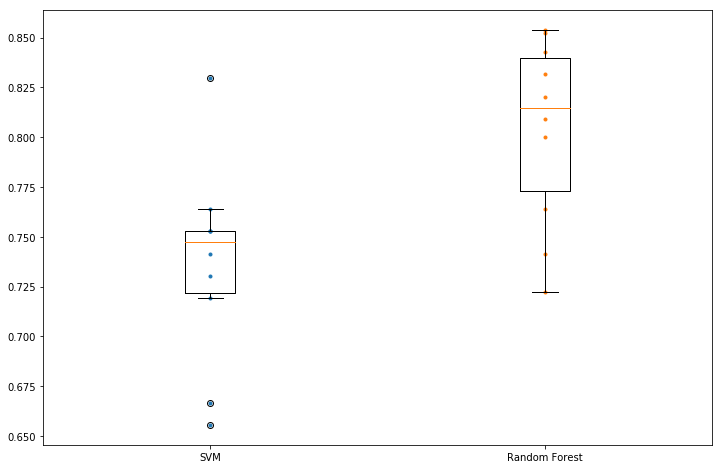

In [44]:
plt.figure(figsize=(12, 8))
plt.plot([1] * 10, svm_scores, '.')
plt.plot([2] * 10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=['SVM', 'Random Forest'])
plt.show()

## Improving the Model

### Feature Engineering

In [61]:
train_data['SibSp_and_Parch'] = train_data['SibSp'] + train_data['Parch']

In [69]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age', 'Fare', 'SibSp_and_Parch'])),
    ('imputer', Imputer(strategy='median')),
])

In [70]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  7.25  ,  1.    ],
       [38.    , 71.2833,  1.    ],
       [26.    ,  7.925 ,  0.    ],
       ...,
       [28.    , 23.45  ,  3.    ],
       [26.    , 30.    ,  0.    ],
       [32.    ,  7.75  ,  0.    ]])

In [71]:
train_data['Age_Bracket'] = train_data['Age'] // 15 * 15

In [74]:
train_data[['Survived', 'Age_Bracket']].groupby('Age_Bracket').mean()

Survived
Age_Bracket          
0.0          0.576923
15.0         0.362745
30.0         0.423256
45.0         0.404494
60.0         0.240000
75.0         1.000000

There could be good correlation between these values.

In [75]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Sex', 'Embarked', 'Pclass', 'Age_Bracket'])),
    ('imputer', MostFrequentImputer()),
    ('encoder', OneHotEncoder(sparse=False))
])

In [76]:
full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [92]:
X_train = full_pipeline.fit_transform(train_data)
X_train

array([[22.    ,  7.25  ,  1.    , ...,  0.    ,  0.    ,  0.    ],
       [38.    , 71.2833,  1.    , ...,  0.    ,  0.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  3.    , ...,  0.    ,  0.    ,  0.    ],
       [26.    , 30.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [80]:
forest_clf_2 = RandomForestClassifier()

In [98]:
forest_scores_2 = cross_val_score(forest_clf_2, X_train, y_train, cv=10, scoring='accuracy')

In [99]:
forest_scores_2.mean()

0.8081863579616388

A gain, but not as much as expected.

Let's do a GridSearch

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
forest_grid_params = {
    'n_estimators': [10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [88]:
forest_grid = GridSearchCV(forest_clf_2, forest_grid_params, scoring='accuracy', cv=3)

In [89]:
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [90]:
forest_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
forest_grid.best_score_

0.8024691358024691

## Testing

In [101]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [103]:
test_data['SibSp_and_Parch'] = test_data['SibSp'] + test_data['Parch']

In [104]:
test_data['Age_Bracket'] = test_data['Age'] // 15 * 15

In [105]:
X_test = full_pipeline.fit_transform(test_data)

In [106]:
best_forest = forest_grid.best_estimator_

In [107]:
test_pred = best_forest.predict(X_test)

In [127]:
test_pred_dict = {'Survived': test_pred}

In [129]:
final_df = pd.concat([test_data['PassengerId'], pd.DataFrame(test_pred_dict)], axis=1)

In [130]:
final_df.to_csv('submission.csv', index=False)